# Installing and Reading in of packages

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
import torch

from model_evaluation import get_model_evaluation
from model_extraction import get_model, get_tokenizer, get_pipeline
from model_training import train_model, train_lora_model

c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

# Reading in of Data

In [4]:
data = pd.read_csv("data/dataset.csv", header = None, names = ["Label", "Text"])
data = data[['Text', 'Label']]

print(data.head()) # First column: 1 - positive, 0 - negative
print(data.shape)

                                                Text  Label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1
(10662, 2)


In [5]:
testing_data = pd.read_csv('data/testing_data.csv')

print(testing_data)

                                                   Text  Label
0     this bracingly truthful antidote to hollywood ...      1
1     once the downward spiral comes to pass , auto ...      1
2     bray is completely at sea ; with nothing but a...      0
3     while the production details are lavish , film...      0
4     anyone who suffers through this film deserves ...      0
...                                                 ...    ...
1595  a dream cast of solid female talent who build ...      1
1596  it's an unusual , thoughtful bio-drama with a ...      1
1597  a gorgeous , somnolent show that is splendidly...      0
1598  it's tough to be startled when you're almost d...      0
1599  george lucas returns as a visionary with a tal...      1

[1600 rows x 2 columns]


# Model (Pre-built on Hugging Face)
For a start, we will try a pre-built model on Hugging Face that will analyse the text and give us a rating on whether it is `POSITIVE` or `NEGATIVE`.

In [6]:
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english") # device = 0
output = sentiment_pipeline(list(testing_data["Text"]))

Device set to use cuda:0


In [7]:
model_predictions = pd.Series(map(lambda x: x['label'], output))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

## Model Evaluation
We will evaluate the model and look at the accuracy of the model.

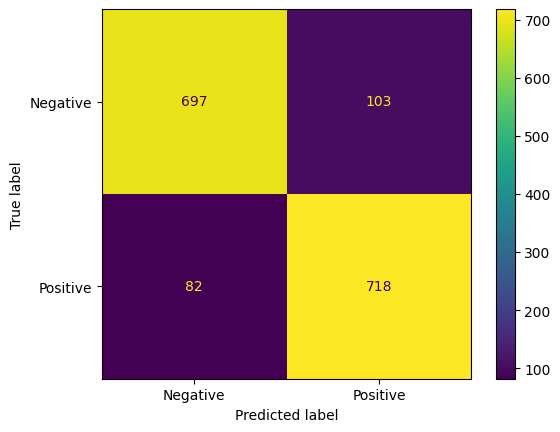

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       800
    Positive       0.87      0.90      0.89       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Accuracy: 0.884375
Recall: 0.8975
Precision: 0.8745432399512789
F1-score: 0.8858729179518815


In [8]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)

# Custom Model
While we see that the pre-built model performs rather well (with an accuracy of around 88%), we will try to train a model on our own and fine-tune it based on the dataset provided. This would hopefully increase the accuracy of the model in determining the sentiment of the input text.

In [9]:
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')
training_model_dir = "google-bert/bert-large-uncased"
# training_model_dir = "google-bert/bert-base-uncased"
# training_model_dir = "distilbert/distilbert-base-uncased"
num_epochs = 10
num_labels = 2 # Only 2 labels - Positive or Negative
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [10]:
train_lora_model(training_data=training_data, 
            validation_data=validation_data, 
            model_dir=training_model_dir,
            num_epochs=num_epochs,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
            )

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Owent\OneDrive\Desktop\Projects\Sentence Sentimental Analysis\model_training.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserv

{'loss': 0.4838, 'grad_norm': 5.052480697631836, 'learning_rate': 1.9095477386934677e-05, 'epoch': 0.5}


 10%|█         | 1000/10000 [03:23<29:32,  5.08it/s]

{'loss': 0.3524, 'grad_norm': 0.4700891375541687, 'learning_rate': 1.8090452261306535e-05, 'epoch': 1.0}


                                                    
 10%|█         | 1000/10000 [03:31<29:32,  5.08it/s]

{'eval_loss': 0.3606138527393341, 'eval_accuracy': 0.8716026241799437, 'eval_f1': 0.8713422550024864, 'eval_precision': 0.8745298654937209, 'eval_recall': 0.8715612285768493, 'eval_runtime': 7.9315, 'eval_samples_per_second': 134.526, 'eval_steps_per_second': 16.895, 'epoch': 1.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 15%|█▌        | 1500/10000 [05:18<41:46,  3.39it/s]  

{'loss': 0.3161, 'grad_norm': 12.148728370666504, 'learning_rate': 1.7085427135678393e-05, 'epoch': 1.5}


 20%|██        | 2000/10000 [07:09<30:55,  4.31it/s]

{'loss': 0.3196, 'grad_norm': 7.296682834625244, 'learning_rate': 1.6080402010050254e-05, 'epoch': 2.0}


                                                    
 20%|██        | 2000/10000 [07:17<30:55,  4.31it/s]

{'eval_loss': 0.33502522110939026, 'eval_accuracy': 0.8856607310215557, 'eval_f1': 0.8856381296430353, 'eval_precision': 0.8859330829922789, 'eval_recall': 0.8856483335792735, 'eval_runtime': 7.9409, 'eval_samples_per_second': 134.367, 'eval_steps_per_second': 16.875, 'epoch': 2.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 25%|██▌       | 2501/10000 [09:11<24:33,  5.09it/s]  

{'loss': 0.2866, 'grad_norm': 4.873752117156982, 'learning_rate': 1.5075376884422112e-05, 'epoch': 2.5}


 30%|███       | 3000/10000 [10:52<23:20,  5.00it/s]

{'loss': 0.2792, 'grad_norm': 23.2009220123291, 'learning_rate': 1.4070351758793972e-05, 'epoch': 3.0}


                                                    
 30%|███       | 3000/10000 [10:59<23:20,  5.00it/s]

{'eval_loss': 0.36763495206832886, 'eval_accuracy': 0.8847235238987816, 'eval_f1': 0.8847231188816718, 'eval_precision': 0.8847341681423392, 'eval_recall': 0.8847260577186584, 'eval_runtime': 6.9828, 'eval_samples_per_second': 152.804, 'eval_steps_per_second': 19.19, 'epoch': 3.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 35%|███▌      | 3500/10000 [12:52<25:54,  4.18it/s]  

{'loss': 0.2398, 'grad_norm': 0.33196815848350525, 'learning_rate': 1.3065326633165832e-05, 'epoch': 3.5}


 40%|████      | 4000/10000 [14:39<20:39,  4.84it/s]

{'loss': 0.2431, 'grad_norm': 1.1119810342788696, 'learning_rate': 1.2060301507537688e-05, 'epoch': 4.0}


                                                    
 40%|████      | 4000/10000 [14:46<20:39,  4.84it/s]

{'eval_loss': 0.4337034821510315, 'eval_accuracy': 0.8837863167760075, 'eval_f1': 0.8837837647918599, 'eval_precision': 0.8838319418676561, 'eval_recall': 0.8837914848465684, 'eval_runtime': 7.5031, 'eval_samples_per_second': 142.208, 'eval_steps_per_second': 17.859, 'epoch': 4.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 45%|████▌     | 4501/10000 [16:30<17:45,  5.16it/s]  

{'loss': 0.2259, 'grad_norm': 15.44446849822998, 'learning_rate': 1.1055276381909548e-05, 'epoch': 4.5}


 50%|█████     | 5000/10000 [18:07<16:03,  5.19it/s]

{'loss': 0.2108, 'grad_norm': 0.10751262307167053, 'learning_rate': 1.0050251256281408e-05, 'epoch': 5.0}


                                                    
 50%|█████     | 5000/10000 [18:14<16:03,  5.19it/s]

{'eval_loss': 0.4709516763687134, 'eval_accuracy': 0.8819119025304593, 'eval_f1': 0.8819109690113134, 'eval_precision': 0.8819314149186606, 'eval_recall': 0.8819153122386885, 'eval_runtime': 6.7117, 'eval_samples_per_second': 158.976, 'eval_steps_per_second': 19.965, 'epoch': 5.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 55%|█████▌    | 5500/10000 [20:03<15:35,  4.81it/s]  

{'loss': 0.1893, 'grad_norm': 15.941712379455566, 'learning_rate': 9.045226130653267e-06, 'epoch': 5.5}


 60%|██████    | 6000/10000 [21:43<12:54,  5.17it/s]

{'loss': 0.1827, 'grad_norm': 0.045294906944036484, 'learning_rate': 8.040201005025127e-06, 'epoch': 6.0}


                                                    
 60%|██████    | 6000/10000 [21:50<12:54,  5.17it/s]

{'eval_loss': 0.5293033719062805, 'eval_accuracy': 0.8809746954076851, 'eval_f1': 0.8808675431771527, 'eval_precision': 0.8824224342833766, 'eval_recall': 0.8810035766736233, 'eval_runtime': 6.8723, 'eval_samples_per_second': 155.26, 'eval_steps_per_second': 19.498, 'epoch': 6.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 65%|██████▌   | 6501/10000 [23:31<11:31,  5.06it/s]  

{'loss': 0.1441, 'grad_norm': 0.04812026396393776, 'learning_rate': 7.035175879396986e-06, 'epoch': 6.5}


 70%|███████   | 7000/10000 [25:22<10:17,  4.85it/s]

{'loss': 0.1749, 'grad_norm': 19.129343032836914, 'learning_rate': 6.030150753768844e-06, 'epoch': 7.0}


                                                    
 70%|███████   | 7000/10000 [25:29<10:17,  4.85it/s]

{'eval_loss': 0.542110800743103, 'eval_accuracy': 0.8772258669165885, 'eval_f1': 0.8771010776966817, 'eval_precision': 0.8788404273335404, 'eval_recall': 0.8772565016056384, 'eval_runtime': 7.2602, 'eval_samples_per_second': 146.967, 'eval_steps_per_second': 18.457, 'epoch': 7.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 75%|███████▌  | 7501/10000 [27:16<08:32,  4.87it/s]  

{'loss': 0.1427, 'grad_norm': 0.35382339358329773, 'learning_rate': 5.025125628140704e-06, 'epoch': 7.5}


 80%|████████  | 8000/10000 [28:59<06:46,  4.92it/s]

{'loss': 0.1402, 'grad_norm': 0.11676956713199615, 'learning_rate': 4.0201005025125635e-06, 'epoch': 8.0}


                                                    
 80%|████████  | 8000/10000 [29:07<06:46,  4.92it/s]

{'eval_loss': 0.5734569430351257, 'eval_accuracy': 0.8762886597938144, 'eval_f1': 0.8762572482867685, 'eval_precision': 0.8767093656354197, 'eval_recall': 0.8763043615742985, 'eval_runtime': 7.4774, 'eval_samples_per_second': 142.697, 'eval_steps_per_second': 17.921, 'epoch': 8.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 85%|████████▌ | 8500/10000 [30:55<05:12,  4.80it/s]  

{'loss': 0.1261, 'grad_norm': 0.05805430933833122, 'learning_rate': 3.015075376884422e-06, 'epoch': 8.5}


 90%|█████████ | 9000/10000 [32:34<03:11,  5.23it/s]

{'loss': 0.1381, 'grad_norm': 0.062469854950904846, 'learning_rate': 2.0100502512562818e-06, 'epoch': 9.0}


                                                    
 90%|█████████ | 9000/10000 [32:40<03:11,  5.23it/s]

{'eval_loss': 0.591587483882904, 'eval_accuracy': 0.8753514526710403, 'eval_f1': 0.8753076428996327, 'eval_precision': 0.875924518476295, 'eval_recall': 0.8753697887022085, 'eval_runtime': 6.8695, 'eval_samples_per_second': 155.324, 'eval_steps_per_second': 19.506, 'epoch': 9.0}


c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:755: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 95%|█████████▌| 9500/10000 [34:35<01:38,  5.07it/s]

{'loss': 0.115, 'grad_norm': 0.06027325987815857, 'learning_rate': 1.0050251256281409e-06, 'epoch': 9.5}


100%|██████████| 10000/10000 [36:16<00:00,  5.18it/s]

{'loss': 0.1329, 'grad_norm': 0.07557268440723419, 'learning_rate': 0.0, 'epoch': 10.0}


                                                     
100%|██████████| 10000/10000 [36:24<00:00,  5.18it/s]

{'eval_loss': 0.5929079651832581, 'eval_accuracy': 0.8762886597938144, 'eval_f1': 0.8762702930634619, 'eval_precision': 0.8765416256504008, 'eval_recall': 0.8763008481424486, 'eval_runtime': 7.8296, 'eval_samples_per_second': 136.277, 'eval_steps_per_second': 17.114, 'epoch': 10.0}


100%|██████████| 10000/10000 [36:25<00:00,  4.58it/s]


{'train_runtime': 2185.3651, 'train_samples_per_second': 36.584, 'train_steps_per_second': 4.576, 'train_loss': 0.22215577545166015, 'epoch': 10.0}


100%|██████████| 134/134 [00:08<00:00, 16.45it/s]


{'eval_loss': 0.33502522110939026, 'eval_accuracy': 0.8856607310215557, 'eval_f1': 0.8856381296430353, 'eval_precision': 0.8859330829922789, 'eval_recall': 0.8856483335792735, 'eval_runtime': 8.2323, 'eval_samples_per_second': 129.611, 'eval_steps_per_second': 16.277, 'epoch': 10.0}
Best model saved at: models/bert-large-uncased_finetunedlora_10epochs_best


In [15]:
model_dir = 'google-bert/bert-large-uncased'
model_name = model_dir.split('/')[1]
num_epochs = 10
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = get_model(model_dir=model_dir, model_name=model_name, num_epochs=num_epochs, num_labels=num_labels, id2label=id2label, label2id=label2id, lora=True)
tokenizer = get_tokenizer(model_name)
pipeline = get_pipeline(model=model, tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [16]:
model_predictions = pd.Series(map(lambda x: x['label'], pipeline(list(testing_data['Text']))))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

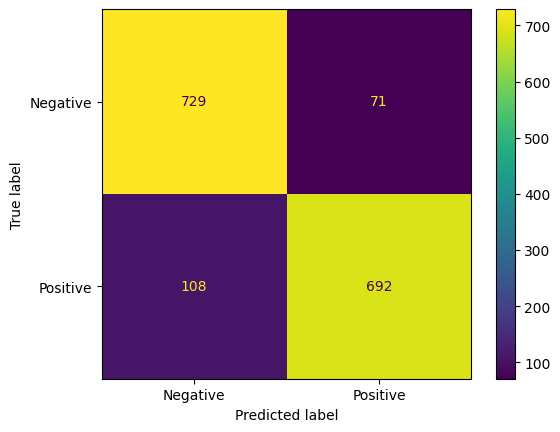

              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       800
    Positive       0.91      0.86      0.89       800

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600

Accuracy: 0.888125
Recall: 0.865
Precision: 0.9069462647444299
F1-score: 0.8854766474728087


In [17]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)